# 心跳数据处理

In [1]:
from __future__ import print_function
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pywt import wavedec

In [2]:
# 小波变换
def separate(y, level):
    coeffs = wavedec(y, 'db1', level = level)
    return coeffs[0]

In [3]:
# 给定一组峰的位置，把距离很近的峰分成一组，返回列表
def groups(peaks, interval):
    res = []
    for i in peaks:
        if res:
            if i - res[-1][0] <= interval:
                res[-1].append(i)
            else:
                res.append([i])
        else:
            res.append([i])
    return res

In [4]:
# 读取数据，返回峰的位置，香农能量
def process(y, level, interval, threshold, sr = 4000, time = 0.02):
    '''
    y：原始数据
    level：小波变换的层数
    interval：间隔，距离小于间隔的峰归为一组
    threshold：香农能量的阈值
    sr：原始数据的采样率，默认4000
    time：计算香农能量的时间窗口，默认0.02秒
    '''
    # 减小噪音
    newy = separate(y, level)
    normy = newy / np.max(np.abs(newy))
    # 香农能量
    ind = np.where(normy == 0)
    normy[ind[0]] = normy[ind[0] + 1]
    pick_num = int(sr * time / (2 ** level))
    square = normy * normy
    energy = -square * np.log(square)
    mean_energy = []
    for i in range(int(len(energy) / 10) - 1):
        mean_energy.append(energy[10*i: 10*i+pick_num].mean())
    mean_energy = np.array(mean_energy)
    mean_energy_norm = (mean_energy - mean_energy.mean()) / mean_energy.std()
    # 导数
    der = np.zeros(len(mean_energy_norm))
    der[1: -1] = mean_energy_norm[2:] - mean_energy_norm[: -2]
    # 选出大于阈值的峰
    peaks = []
    for i in range(0, len(der)):
        if i == 0 or i == len(der) - 1:
            if mean_energy_norm[i] >= 1:
                peaks.append(i)
        elif mean_energy_norm[i] >= threshold and der[i-1] > 0 and der[i+1] < 0:
            peaks.append(i)
    # 相近的峰归类，选择强度最大的
    group = groups(peaks, interval)
    pos = []
    for item in group:
        sub = []
        for i in item:
            sub.append(mean_energy_norm[i])
        pos.append(item[sub.index(max(sub))])
    res = []
    for i in pos:
        res.append([i * 10 * 2 ** level, mean_energy_norm[i]])
    res = np.array(res)
    return res, mean_energy_norm

In [5]:
# 画出峰形和选出的峰，方便检查
def plot(label, res, mean_energy_norm, level = 3):
    plt.plot(np.arange(len(mean_energy_norm)) * 10 * 2 ** level, mean_energy_norm)
    plt.title('Energy')
    plt.plot(res[:, 0], res[:, 1], 'yx')
    plt.plot(label, mean_energy_norm[(label / (10 * 2 ** level)).astype(int)] / 2, 'ro')
    plt.show()

In [6]:
# 删除间距偏离正常值的峰
def delete_peak(peaks, peak_threshold):
    peak = peaks[:, 0].copy()
    origin = peak.copy()
    for i in range(len(peak) - 1):
        if peak[i+1] - peak[i] <= peak_threshold:
            peak[i+1] = peak[i]
    new_peak = peaks[peak == origin]
    return new_peak

In [7]:
# 导入数据
path_b = 'Btraining_normal_seg.csv'
file_b = pd.read_csv(path_b, index_col = 0)
name_b = file_b.index

path_b = []
data_b = []
s_r_b = []
for i in range(len(name_b)):
    path_b.append('Btraining_normal/' + name_b[i])
    try:
        y, sr = librosa.load(path_b[-1], sr = None)
        data_b.append(y)
        s_r_b.append(sr)
    except:
        print (name_b[i])
        continue

label_b = []
for i in range(len(data_b)):
    label_b.append(file_b.loc[name_b[i]][pd.notnull(file_b.loc[name_b[i]])])


path_b_test = 'Evaluation/Challenge1_evaluation_sheet.xlsx'
file_b_test = pd.read_excel(path_b_test, sheetname = 1, index_col = 0)
name_b_test = file_b_test.index
name_b_test = name_b_test[: 30]

path_b_test = []
data_b_test = []
s_r_b_test = []
for i in range(len(name_b_test)):
    path_b_test.append('Btraining_normal/' + name_b_test[i])
    try:
        y, sr = librosa.load(path_b_test[-1], sr = None)
        data_b_test.append(y)
        s_r_b_test.append(sr)
    except:
        print (name_b_test[i])
        continue

In [8]:
# 计算训练集，测试集的香农能量，选择峰，结果保存在列表
all_peak_b = []
all_energy_b = []
for i in range(len(data_b)):
    res, mean_energy_norm = process(data_b[i], 3, 5, 0.05)
    all_peak_b.append(delete_peak(res, 500))
    all_energy_b.append(mean_energy_norm)

all_peak_b_test = []
all_energy_b_test = []
for i in range(len(data_b_test)):
    res, mean_energy_norm = process(data_b_test[i], 3, 5, 0.05)
    all_peak_b_test.append(delete_peak(res, 500))
    all_energy_b_test.append(mean_energy_norm)

In [9]:
# 每个样本生成一个DataFrame，训练样本添加标签
alldf_b = []
col1 = ['energy', 'train_pos', 'label_pos', 'label_class']
for j in range(len(label_b)):
    temp = pd.DataFrame({'train_pos': all_peak_b[j][:, 0], 'energy': all_peak_b[j][:, 1]}, columns = col1)
    store = label_b[j]
    # 找到每个标签对应的位置
    for i in range(len(store)):
        l = list(all_peak_b[j][:, 0])
        length = len(l)
        l.append(store[i])
        l.sort()
        ind = l.index(store[i])
        if ind == 0:
            pos = 0
        elif ind == len(l) - 1:
            pos = length - 1
        else:
            if store[i] - l[ind-1] < l[ind+1] - store[i]:
                pos = ind - 1
            else:
                pos = ind
        if 'S1' in store.index[i]:
            target_class = 'S1'
        else:
            target_class = 'S2'
        temp.loc[pos, 'label_pos'] = store[i]
        temp.loc[pos, 'label_class'] = target_class
    alldf_b.append(temp)

alldf_b_test = []
col2 = ['energy', 'train_pos']
for j in range(len(data_b_test)):
    temp = pd.DataFrame({'train_pos': all_peak_b_test[j][:, 0], 'energy': all_peak_b_test[j][:, 1]}, columns = col2)
    alldf_b_test.append(temp)

In [10]:
alldf_b2 = []
for i in range(len(alldf_b)):
    alldf_b2.append(alldf_b[i].copy())

alldf_b2_test = []
for i in range(len(alldf_b_test)):
    alldf_b2_test.append(alldf_b_test[i].copy())

In [11]:
# 生成特征
# 根据3份报告的预测结果作图发现，预测准确率高的样本峰间距离变化有规律，准确率低的样本峰间距离不规律。所以峰间距离影响很大，其次是能量变化。
def feature(df, status):
    temp = np.array(df.train_pos)
    pos_gap = np.zeros_like(temp)
    pos_gap[-1] = temp[-1] - temp[-2]
    pos_gap[0: -1] = temp[1:] - temp[0: -1]
    # 相邻峰的距离
    df['pos_gap'] = pos_gap
    # 峰间距离平均值
    df['pos_mean'] = pos_gap.mean()
    # 峰间距离标准差
    df['pos_std'] = pos_gap.std()
    # 每个峰间距离偏离平均值的程度
    df['gap_ratio'] = pos_gap / pos_gap.mean()
    # 峰间距离的相似程度，不大于120则认为相似
    sim_gap = np.zeros_like(temp)
    sim_gap[1: ] = (np.abs(pos_gap[1: ] - pos_gap[0: -1]) <= 120).astype(int)
    sim_gap[0] = 1
    df['sim_gap'] = sim_gap
    # 峰间距离的比值
    gap_diff = np.zeros_like(temp)
    gap_diff[0: -1] = pos_gap[0: -1] / pos_gap[1: ]
    gap_diff[-1] = 1
    df['gap_diff'] = gap_diff
    
    temp1 = np.array(df.energy)
    en_gap = np.zeros_like(temp1)
    en_gap[-1] = temp1[-2] - temp1[-1]
    en_gap[0: -1] = temp1[1:] - temp1[0: -1]
    # 能量差
    df['energy_gap'] = en_gap
    # 能量平均值
    df['energy_mean'] = temp1.mean()
    # 能量标准差
    df['energy_std'] = temp1.std()
    # 能量偏离平均值的程度
    df['energy_ratio'] = temp1 / temp1.mean()
    # 相邻能量的比值
    en_diff = np.zeros_like(temp1)
    en_diff[0: -1] = temp1[0: -1] / temp1[1: ]
    en_diff[-1] = 1
    df['energy_diff'] = en_diff
    
    if status == 'train':
        # 训练样本的类别标签从字符改为数字，S1——1，S2——2，假峰——3
        df.loc[df.label_class == 'S1', 'label_class'] = 1
        df.loc[df.label_class == 'S2', 'label_class'] = 2
        df.label_class.fillna(3, inplace = True)
        # 生成模式标签，假峰——3，和前一个真峰不同——1，和前一个真峰相同——0
        temp2 = np.array(df.label_class)
        mode = np.ones_like(temp2)
        mode[temp2 == 3] = 3
        store1 = mode[mode != 3]
        store2 = store1[1: ]
        store2[temp2[temp2 != 3][1: ] == temp2[temp2 != 3][0: -1]] = 0
        store1[1: ] = store2
        mode[mode != 3] = store1
        df['norm_mode'] = mode
    
    return df

In [12]:
# 训练样本，测试样本添加特征，所有训练样本合成为一个DataFrame
for i in range(len(data_b)):
    if i == 0:
        train_b2 = feature(alldf_b2[i], 'train')
    else:
        train_b2 = train_b2.append(feature(alldf_b2[i], 'train'), ignore_index = True)

for i in range(len(data_b_test)):
    alldf_b2_test[i] = feature(alldf_b2_test[i], 'test')

In [13]:
# 建模预测
'''
两种预测方法：
1 预测峰的类型（S1，S2，假峰）。使用支持向量机，决策树，逻辑斯蒂回归，随机森林，准确率大约在75—80%。测试集误差大约在170000左右。
2 预测峰的模式。理想的峰形S1-S2间距小于S2-S1间距，同时S1强度大于S2。
正常模式下，相邻两个峰类型应该不同。同时模式和峰间距离，能量相关性更大。
如果模式正常，标记为1，之后还原为和之前真峰不同的类型；反之标记为0，之后还原为和之前真峰相同的类型。
这里使用第2种预测方法，测试集误差为40000左右，显著低于第1种方法，也低于报告中的结果（70000左右）。
'''
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

pick_col = ['energy', 'train_pos', 'pos_gap', 'pos_mean', 'pos_std', 'gap_diff', 'gap_ratio', 'sim_gap',\
            'energy_gap', 'energy_mean', 'energy_std', 'energy_diff', 'energy_ratio']
x = train_b2[pick_col]
y = np.array(train_b2[['norm_mode']]).reshape(1, -1)[0]
mean = x.mean()
std = x.std()
x_scale = (x - mean) / std
x_train, x_test, y_train, y_test = train_test_split(x_scale, y, test_size = 0.3, random_state=10, stratify=y)

In [14]:
clf1 = SVC()
clf1.fit(x_train, y_train)
pred = clf1.predict(x_test)
(pred == y_test).mean()

0.9772209567198178

In [15]:
clf2 = DecisionTreeClassifier()
clf2 = clf2.fit(x_train, y_train)
pred = clf2.predict(x_test)
(pred == y_test).mean()

0.9772209567198178

In [16]:
clf3 = LogisticRegression()
clf3 = clf3.fit(x_train, y_train)
pred = clf3.predict(x_test)
(pred == y_test).mean()

0.9772209567198178

In [17]:
clf4 = RandomForestClassifier()
clf4 = clf4.fit(x_train, y_train)
pred = clf4.predict(x_test)
(pred == y_test).mean()

0.9817767653758542

In [18]:
# 每个测试样本单独生成一个DataFrame，增加特征，写入预测结果
for i in range(30):
    x = alldf_b2_test[i][pick_col]
    x_scale = (x - mean) / std
    test_pred = clf4.predict(x_scale)
    alldf_b2_test[i]['pred'] = test_pred

In [19]:
# 将预测结果还原为峰的类型，结果生成为DataFrame，写入Excel文件。
output = pd.DataFrame(columns = range(1, 101))
for k in range(30):
    # 针对每个样本还原为峰的类型，写入DataFrame
    mode = np.array(alldf_b2_test[k].pred)
    result = np.ones_like(mode)
    result[mode == 3] = 3
    store1 = result[result != 3]
    store2 = mode[mode != 3]
    for j in range(len(store2) - 1):
        if store2[j+1] == 1:
            store1[j+1] = 3 - store1[j]
        else:
            store1[j+1] = store1[j]
    result[result != 3] = store1
    alldf_b2_test[k]['predict_class'] = result
    
    # 汇总结果
    j = 0
    output.loc[k, :] = np.nan
    for i in range(len(alldf_b2_test[k])):
        if alldf_b2_test[k].loc[i, 'predict_class'] == 3:
            continue
        if (alldf_b2_test[k].loc[i, 'predict_class'] + output.columns[j]) % 2 == 0:
            output.iloc[k, j] = alldf_b2_test[k].iloc[i, 1]
        else:
            j += 1
            output.iloc[k, j] = alldf_b2_test[k].iloc[i, 1]
        j += 1

output.to_excel('output.xlsx')

测试集误差
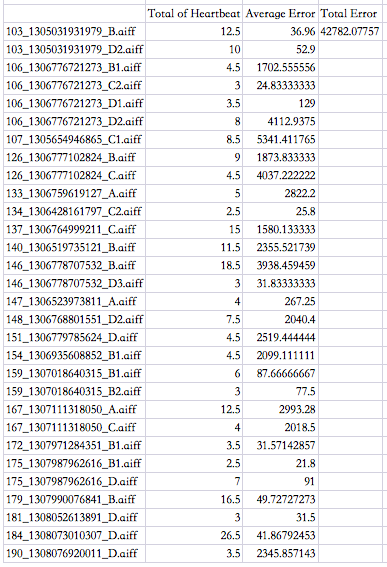